/tmp/ipykernel_3302775/1175180966.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cax1 = axes[0].pcolormesh(Theta.T, R.T, scales_on_xy_plane[:, :, 0], cmap='viridis')
/tmp/ipykernel_3302775/1175180966.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cax2 = axes[1].pcolormesh(Theta.T, R.T, scales_on_xy_plane[:, :, 1], cmap='viridis')
/tmp/ipykernel_3302775/1175180966.py:61: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cax3 = axes[2].pcolormesh(Theta.T, R.T, scales_on_xy_plane[:, :, 2], cmap='viridis')


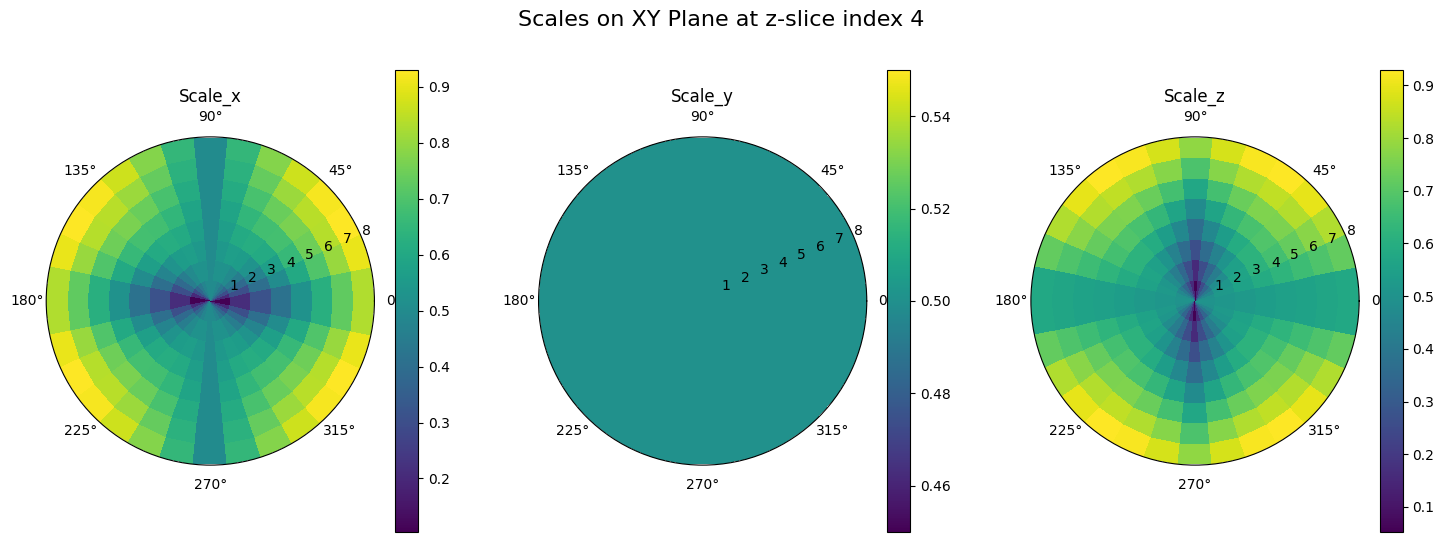

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 首先，我们复用上一问的函数来生成数据
def initialize_scales_for_cylindrical_grid(
    theta_res: int, 
    r_res: int,
    z_res: int,
    r_min: float, 
    r_max: float,
    z_min: float,
    z_max: float
) -> torch.Tensor:
    delta_r = (r_max - r_min) / r_res
    delta_z = (z_max - z_min) / z_res
    delta_theta = 2 * np.pi / theta_res
    theta_vals = torch.linspace(0, 2 * np.pi, theta_res + 1)[:-1] + delta_theta / 2
    r_vals = torch.linspace(r_min, r_max, r_res + 1)[:-1] + delta_r / 2
    z_vals = torch.linspace(z_min, z_max, z_res + 1)[:-1] + delta_z / 2
    grid_r, grid_theta, grid_z = torch.meshgrid(r_vals, theta_vals, z_vals, indexing='ij')
    cos_theta, sin_theta = torch.cos(grid_theta), torch.sin(grid_theta)
    delta_y_values = torch.full_like(grid_z, delta_z)
    delta_z = torch.abs(cos_theta) * delta_r + torch.abs(grid_r * sin_theta) * delta_theta
    delta_x = torch.abs(sin_theta) * delta_r + torch.abs(grid_r * cos_theta) * delta_theta
    scales = torch.stack([delta_x / 2, delta_y_values / 2, delta_z / 2], dim=-1)
    return scales, r_vals, theta_vals

# --- 生成数据 ---
theta_0, r_0, z_0 = 30, 8, 8
R_min, R_max = 0.0, 8.0
Z_min, Z_max = -4.0, 4.0

initial_scales, r_coords, theta_coords = initialize_scales_for_cylindrical_grid(
    theta_0, r_0, z_0, R_min, R_max, Z_min, Z_max
)

# --- 开始可视化 ---
# 选择一个中间的高度切片来观察
z_slice_index = z_0 // 2
scales_on_xy_plane = initial_scales[:, :, z_slice_index, :].numpy() # 形状变为 [r_res, theta_res, 3]

# 准备极坐标网格
R, Theta = np.meshgrid(r_coords.numpy(), theta_coords.numpy())

# 创建一个figure，包含3个子图，分别显示 sx, sy, sz
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection='polar'))
fig.suptitle(f'Scales on XY Plane at z-slice index {z_slice_index}', fontsize=16)

# 绘制 scale_x
cax1 = axes[0].pcolormesh(Theta.T, R.T, scales_on_xy_plane[:, :, 0], cmap='viridis')
axes[0].set_title('Scale_x')
fig.colorbar(cax1, ax=axes[0])

# 绘制 scale_y
cax2 = axes[1].pcolormesh(Theta.T, R.T, scales_on_xy_plane[:, :, 1], cmap='viridis')
axes[1].set_title('Scale_y')
fig.colorbar(cax2, ax=axes[1])

# 绘制 scale_z
cax3 = axes[2].pcolormesh(Theta.T, R.T, scales_on_xy_plane[:, :, 2], cmap='viridis')
axes[2].set_title('Scale_z')
fig.colorbar(cax3, ax=axes[2])

plt.show()

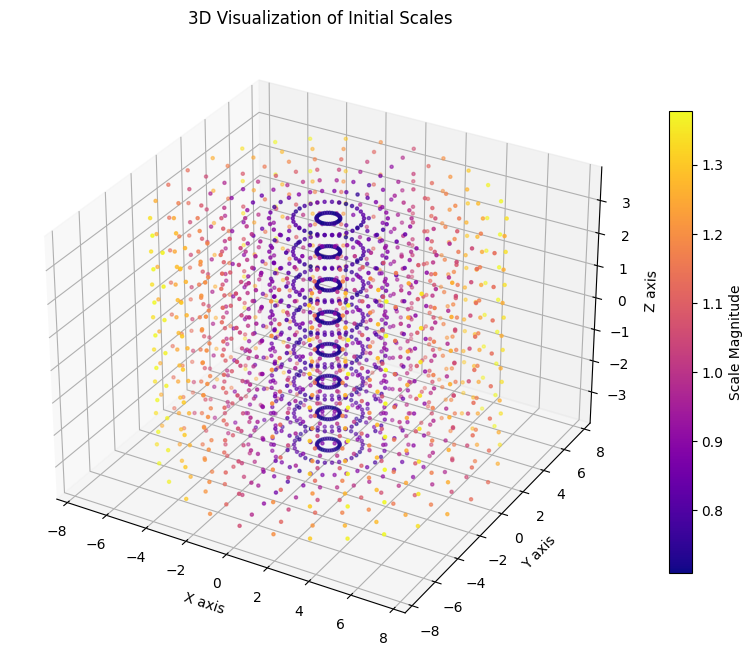

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 复用上面的函数和数据生成部分 ---
# ... (省略)
# initial_scales 的形状为 [r_res, theta_res, z_res, 3]
# 同时需要创建网格来获取 r, theta, z 的坐标
r_vals = torch.linspace(R_min, R_max, r_0 + 1)[:-1] + (R_max - R_min) / r_0 / 2
theta_vals = torch.linspace(0, 2*np.pi, theta_0 + 1)[:-1] + (2*np.pi) / theta_0 / 2
z_vals = torch.linspace(Z_min, Z_max, z_0 + 1)[:-1] + (Z_max - Z_min) / z_0 / 2
grid_r, grid_theta, grid_z = torch.meshgrid(r_vals, theta_vals, z_vals, indexing='ij')

# --- 开始3D可视化 ---

# 1. 将球坐标转换为笛卡尔坐标(x, y, z)以便绘图
x = grid_r * torch.cos(grid_theta)
y = grid_r * torch.sin(grid_theta)
z = grid_z
points_xyz = torch.stack([x, y, z], dim=-1).reshape(-1, 3).numpy()

# 2. 计算每个高斯球的scale的模长（代表总体积大小）
scales_flat = initial_scales.reshape(-1, 3).numpy()
scale_magnitudes = np.linalg.norm(scales_flat, axis=-1)

# 3. 绘制3D散点图
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 使用 scale_magnitudes 来决定每个点的颜色
scatter = ax.scatter(
    points_xyz[:, 0], 
    points_xyz[:, 1], 
    points_xyz[:, 2], 
    c=scale_magnitudes, 
    cmap='plasma',
    s=5  # 点的大小
)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Visualization of Initial Scales')
fig.colorbar(scatter, ax=ax, shrink=0.6, label='Scale Magnitude')
plt.show()